In [17]:
import numpy as np

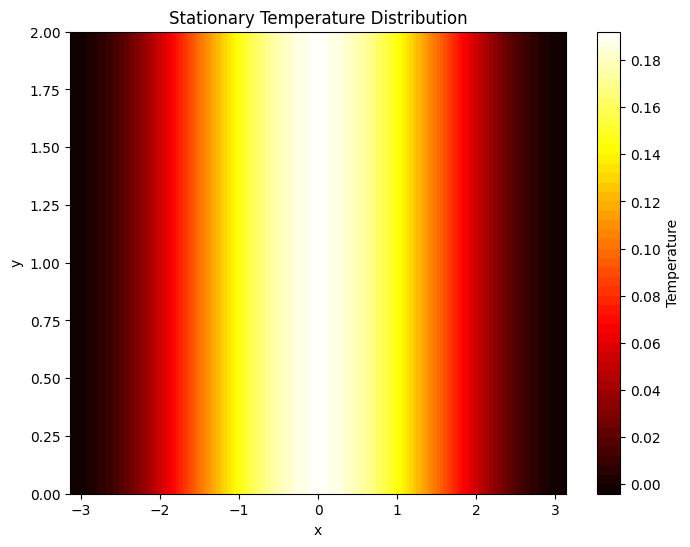

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, linalg

N = 32
M = 32
Lx = np.pi
Ly = 2
dx = 2 * Lx / N
dy = Ly / M


x = np.linspace(-Lx, Lx, N)
y = np.linspace(0, Ly, M)
X, Y = np.meshgrid(x, y, indexing='ij')

F = -np.cos(X)

alpha_x = 1 / dx**2
alpha_y = 1 / dy**2

diagonals_x = [np.ones(N) * (-2 * alpha_x), np.ones(N-1) * alpha_x, np.ones(N-1) * alpha_x]
Lx_matrix = diags(diagonals_x, [0, -1, 1], shape=(N, N)).toarray()
Lx_matrix[0, -1] = alpha_x
Lx_matrix[-1, 0] = alpha_x

diagonals_y = [np.ones(M) * (-2 * alpha_y), np.ones(M-1) * alpha_y, np.ones(M-1) * alpha_y]
Ly_matrix = diags(diagonals_y, [0, -1, 1], shape=(M, M)).toarray()
Ly_matrix[-1, -2] = 2 * alpha_y

A = kron(eye(M), Lx_matrix) + kron(Ly_matrix, eye(N))

b = F.flatten()

u = linalg.spsolve(A, b)

U = u.reshape(N, M)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, U, levels=50, cmap='hot')
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stationary Temperature Distribution")
plt.show()


In [19]:
Lx_matrix

array([[-0.81056947,  0.40528473,  0.        ,  0.40528473],
       [ 0.40528473, -0.81056947,  0.40528473,  0.        ],
       [ 0.        ,  0.40528473, -0.81056947,  0.40528473],
       [ 0.40528473,  0.        ,  0.40528473, -0.81056947]])

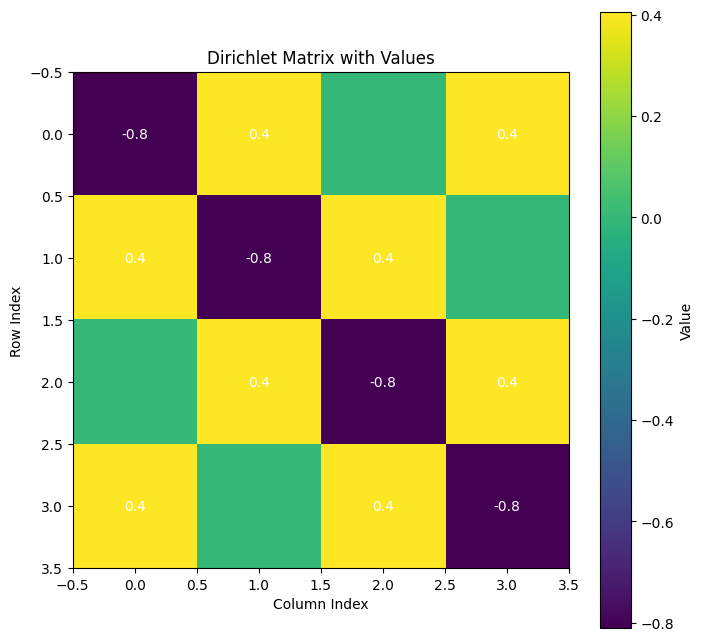

In [20]:
def visualize_matrix(A):
    # Convert sparse matrix to dense for visualization
    # A_dense = A.toarray()
    A_dense = A
    
    plt.figure(figsize=(8, 8))
    plt.imshow(A_dense, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    
    # Annotate each cell with the numeric value
    for (i, j), val in np.ndenumerate(A_dense):
        if val != 0:  # Only annotate non-zero values
            plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='white')
    
    plt.title('Dirichlet Matrix with Values')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
visualize_matrix(Lx_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12400 stored elements and shape (2500, 2500)>

In [16]:
import numpy as np
from scipy.sparse import lil_matrix
def dirichlet_matrix(J):
    # Initialize sparse matrix A
    A = lil_matrix(((J-1)**2, (J-1)**2))
    
    def idx(i, j):
        return (i - 1) * (J - 1) + (j - 1)  # Adjusted for 0-based indexing

    for i in range(1, J):
        for j in range(1, J):
            k = idx(i, j)
            # Central point contribution
            A[k, k] = -4
            # Neighbor contributions
            if i > 1:
                A[k, idx(i - 1, j)] = 1  # West
            if i < J - 1:
                A[k, idx(i + 1, j)] = 1  # East
            if j > 1:
                A[k, idx(i, j - 1)] = 1  # South
            if j < J - 1:
                A[k, idx(i, j + 1)] = 1  # North

    # Dirichlet conditions encoding
    # Set the first row to 0 (left boundary)
    A[0, :] = 0
    A[0, 0] = 1  # u(0, y) = 0

    # Set the last row to 1 (right boundary)
    A[-1, :] = 0
    A[-1, -1] = 1  # u(1, y) = 1

    return A.tocsr()  # Convert to CSR format for efficient arithmetic and matrix-vector 

def periodic_matrix_y(J):
    # Initialize sparse matrix A
    A = lil_matrix(((J-1)**2, (J-1)**2))
    
    def idx(i, j):
        return (i - 1) * (J - 1) + (j - 1)  # Adjusted for 0-based indexing

    for i in range(1, J):
        for j in range(1, J):
            k = idx(i, j)
            # Central point contribution
            A[k, k] = -4

            # Neighbor contributions
            if i > 1:
                A[k, idx(i - 1, j)] = 1  # West
            if i < J - 1:
                A[k, idx(i + 1, j)] = 1  # East
            if j > 1:
                A[k, idx(i, j - 1)] = 1  # South
            if j < J - 1:
                A[k, idx(i, j + 1)] = 1  # North
            
            # Wrap around North/South (periodic boundary conditions)
            if j == 1:
                A[k, idx(i, J - 1)] = 1  # North periodic
            if j == J - 1:
                A[k, idx(i, 1)] = 1  # South periodic

    # Dirichlet conditions
    A[0, :] = 0
    A[0, 0] = 1  # u(0, y) = 0
    A[-1, :] = 0
    A[-1, -1] = 1  # u(1, y) = 1

    return A.tocsr()

def periodic_matrix_x(J):
    # Initialize sparse matrix A
    A = lil_matrix(((J-1)**2, (J-1)**2))
    
    def idx(i, j):
        return (i - 1) * (J - 1) + (j - 1)  # Adjusted for 0-based indexing

    for i in range(1, J):
        for j in range(1, J):
            k = idx(i, j)
            # Central point contribution
            A[k, k] = -4

            # Neighbor contributions
            if i > 1:
                A[k, idx(i - 1, j)] = 1  # West
            if i < J - 1:
                A[k, idx(i + 1, j)] = 1  # East
            if j > 1:
                A[k, idx(i, j - 1)] = 1  # South
            if j < J - 1:
                A[k, idx(i, j + 1)] = 1  # North
            
            # Wrap around West/East (periodic boundary conditions)
            if i == 1:
                A[k, idx(J - 1, j)] = 1  # West periodic
            if i == J - 1:
                A[k, idx(1, j)] = 1  # East periodic

    # Dirichlet conditions on top and bottom
    A[0, :] = 0
    A[0, 0] = 1  # u(x, 0) = 0
    A[-1, :] = 0
    A[-1, -1] = 0  # Zero gradient at bottom

    return A.tocsr()

import matplotlib.pyplot as plt
def visualize_matrix(A):
    # Convert sparse matrix to dense for visualization
    A_dense = A.toarray()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(A_dense, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    
    # Annotate each cell with the numeric value
    for (i, j), val in np.ndenumerate(A_dense):
        if val != 0:  # Only annotate non-zero values
            plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='white')
    
    plt.title('Dirichlet Matrix with Values')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()



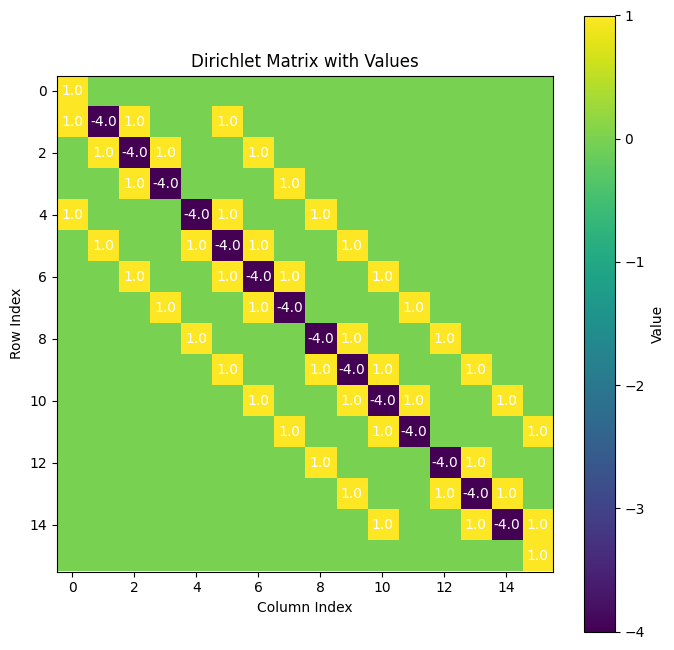

In [17]:
# Example usage
J = 5  # Size parameter
A = dirichlet_matrix(J)
visualize_matrix(A)

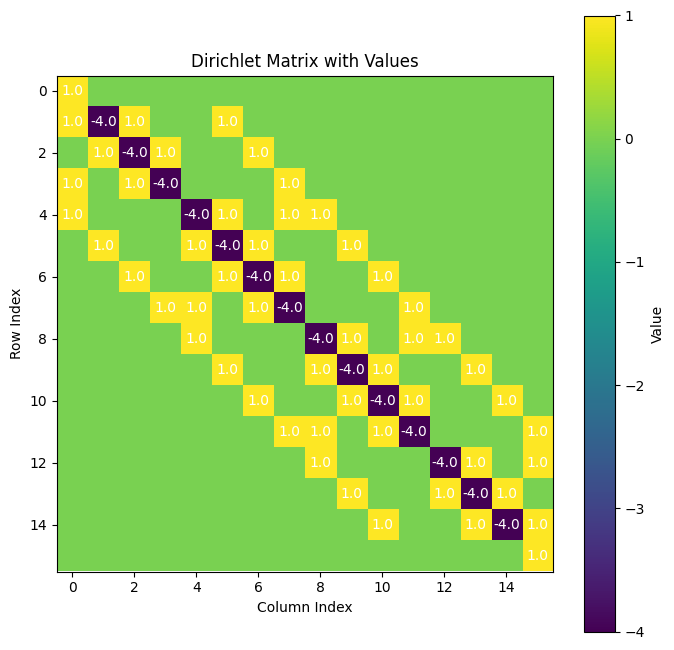

In [18]:
# Example usage
J = 5  # Size parameter
A = periodic_matrix_y(J)
visualize_matrix(A)

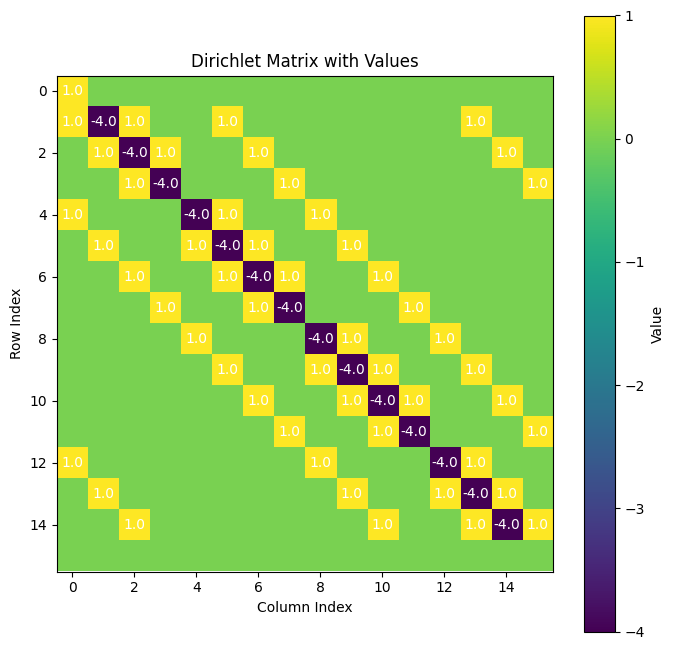

In [19]:

# Example usage
J = 5  # Size parameter
A = periodic_matrix_x(J)
visualize_matrix(A)